# Scanning over Baryon Abundance and Neutron Decay Lifetime

## Preamble

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

import numpy as np
import jax.numpy as jnp
from jax import vmap, jit
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

%matplotlib inline

In [3]:
# Load plot settings

from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
from linx.background import BackgroundModel
from linx.nuclear import NuclearRates 
from linx.abundances import AbundanceModel
from linx.const import eta0, sigma_eta0, tau_n, sigma_tau_n 

This notebook demonstrates how to scan over various parameters using LINX. We will perform a 2D scan of the BBN likelihood assuming SBBN, as we vary $\Omega_b h^2$ and $\tau_n$. 

First, we compute the background quantities. 

In [5]:
bkg_model = BackgroundModel()

# Call the class. 
t_vec, a_vec, rho_g_vec, rho_nu_vec, rho_NP_vec, p_NP_vec, Neff_vec = bkg_model(jnp.asarray(0.))

`\         /´  ||||        ||||  |||||     ||||  ||||   ||||
 /\_______/\   ||||        ||||  |||||||   ||||   |||| ||||
 ) __` ´__ (   ||||        ||||  |||| |||| ||||    |||||||
/  `-|_|-´  \  ||||        ||||  ||||  |||| |||    ||||||| 
/   (_x_)   \  ||||||||||  ||||  ||||   |||||||   |||| ||||
  )  `-´  (    ||||||||||  ||||  ||||    ||||||  ||||   ||||
 
Compiling thermodynamics model...


Next, we define an abundance model. We'll pick the `key_PRIMAT_2023` nuclear network. 

In [6]:
abd_model = AbundanceModel(
    NuclearRates(nuclear_net='key_PRIMAT_2023')
)

We define the following BBN likelihood, based on Aver et al. and Cooke et al. for experimental measurements of $\text{Y}_\text{P}$ and D/H respectively: 
$$
    -2 \log \mathcal{L} = \left( \frac{\text{D/H}^\text{pred} - \text{D/H}^\text{obs}}{\sigma_{\text{D/H}^\text{obs}}} \right)^2 + \left( \frac{\text{Y}_\text{P}^\text{pred} - \text{Y}_\text{P}^\text{obs}}{\sigma_{\text{Y}_\text{P}^\text{obs}}} \right)^2
$$
We'll write a function for $-2 \log \mathcal{L}$, which we take to be a function of `eta_fac` and `tau_n_fac`, factors that multiply the default values of $\Omega_b h^2$ (found in `const.omegabh2`) and $\tau_n$ (found in `const.tau_n`) in the calculation. 

In [7]:
DH_obs_mean = 2.527e-5
DH_obs_sig  = 0.03e-5

YP_obs_mean = 0.2449
YP_obs_sig  = 0.004 

In [8]:
nuclear_rates_q = jnp.zeros(12) 

def get_m2LL(eta_fac, tau_n_fac): 

    sol = abd_model(
        rho_g_vec, rho_nu_vec, 
        rho_NP_vec, p_NP_vec,
        t_vec=t_vec, a_vec=a_vec, 
        eta_fac = jnp.asarray(eta_fac), 
        tau_n_fac = jnp.asarray(tau_n_fac), 
        nuclear_rates_q = nuclear_rates_q
    )

    DH_pred = sol[2] / sol[1] 
    YP_pred = sol[5] * 4 

    return ((DH_pred - DH_obs_mean) / DH_obs_sig)**2 + ((YP_pred - YP_obs_mean) / YP_obs_sig)**2 

We now define a vectorized version of `get_m2LL`. We want to vectorize over both `eta_fac` and `tau_n_fac`, so this requires nested calls of `vmap`: the inside call vectorizes over `tau_n_fac`, and the outside call vectorizes over `eta_fac`. The final `jit` function compiles everything. The function `get_m2LL_v` outputs an array that has dimensions `eta_fac x tau_n_fac`. 

In [9]:
get_m2LL_v = jit(vmap(vmap(get_m2LL, in_axes=(None,0)), in_axes=(0,None))) 

Next, we define the values of $\eta$ and $\tau_n$ to scan over, and then obtain an array of $-2 \log \mathcal{L}$: 

In [10]:
eta_ary = np.logspace(np.log10(5.5e-10), np.log10(7e-10), num=50)
eta_fac_ary = eta_ary/eta0



tau_n_fac_ary = np.linspace(
    tau_n - 200*sigma_tau_n, 
    tau_n + 200*sigma_tau_n,
    num=60
) / tau_n

m2LL = get_m2LL_v(eta_fac_ary, tau_n_fac_ary)


Compiling abundance model...


Now make the plot! We plot 68% and 95% containment, taking $2 \log \mathcal{L} -2 \log \mathcal{L}_*$ to follow a $\chi^2$ distribution with two degrees of freedom, where $\mathcal{L}_*$ is the maximum likelihood point. We also show existing laboratory limits on $\tau_n$, and the preferred region for $\eta$ by Planck CMB anisotropy power spectrum measurements. 

Once again, for `key_PRIMAT_2023`, a discrepancy in the inferred value of the baryon abundance can be seen between BBN and CMB. We can also see that the sensitivity of BBN to $\tau_n$ is much less than current laboratory experiments. 

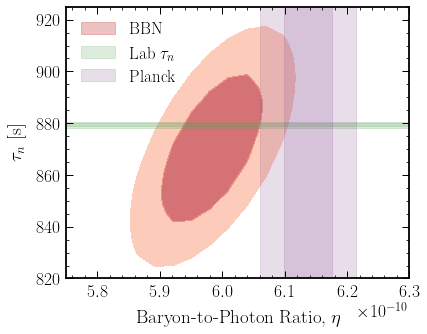

In [12]:
plt.figure()

plt.contourf(eta_ary, tau_n_fac_ary * tau_n, np.transpose(m2LL - np.min(m2LL)), levels=(0, 2.30, 5.99), cmap='Reds_r', alpha=0.6)


plt.fill_between(x=eta_ary, y1=0., y2=0., color=cols_default[0], alpha=0.3, label=r'BBN')

plt.fill_between(x=eta_ary, y1=tau_n - sigma_tau_n, y2=tau_n + sigma_tau_n, alpha=0.2, color=cols_default[2], label=r'Lab $\tau_n$')
plt.fill_between(x=eta_ary, y1=tau_n - 2*sigma_tau_n, y2=tau_n + 2*sigma_tau_n, alpha=0.2, color=cols_default[2])
plt.fill_betweenx(y=[700, 1000], x1=eta0 - sigma_eta0, x2=eta0 + sigma_eta0,   alpha=0.2, color=cols_default[3], label=r'Planck')
plt.fill_betweenx(y=[700, 1000], x1=eta0 - 2*sigma_eta0, x2=eta0 + 2*sigma_eta0,   alpha=0.2, color=cols_default[3])


plt.xlim(5.75e-10, 6.3e-10)
plt.ylim(820, 925)

plt.xlabel(r'Baryon-to-Photon Ratio, $\eta$')
plt.ylabel(r'$\tau_n$ [s]')

plt.legend(loc='upper left')